##Importing Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import datetime
import random

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
print(f'Month sold type: {train_df["MoSold"].dtype}')
print(f'Year sold type: {train_df["YrSold"].dtype}')

Month sold type: int64
Year sold type: int64


Converting Dates to String Types

In [4]:
train_df['MoSold'] = train_df['MoSold'].astype(str)

Checking for unexpected negative values

In [5]:
numerical_columns = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

negatives = (train_df[numerical_columns] < 0).sum()
print(negatives)

Id               0
MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
YrSold           0
SalePrice        0
dtype: int64


## General EDA

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,2010.000000,755000.000000


Dropping 'ID' Columns

In [8]:
test_id = test_df["Id"]

train_df.drop(columns="Id", inplace=True)
test_df.drop(columns="Id", inplace=True)

Heatmap of variables correlated with SalePrice

<ipython-input-9-eee2888e11ad>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train_df.corr()


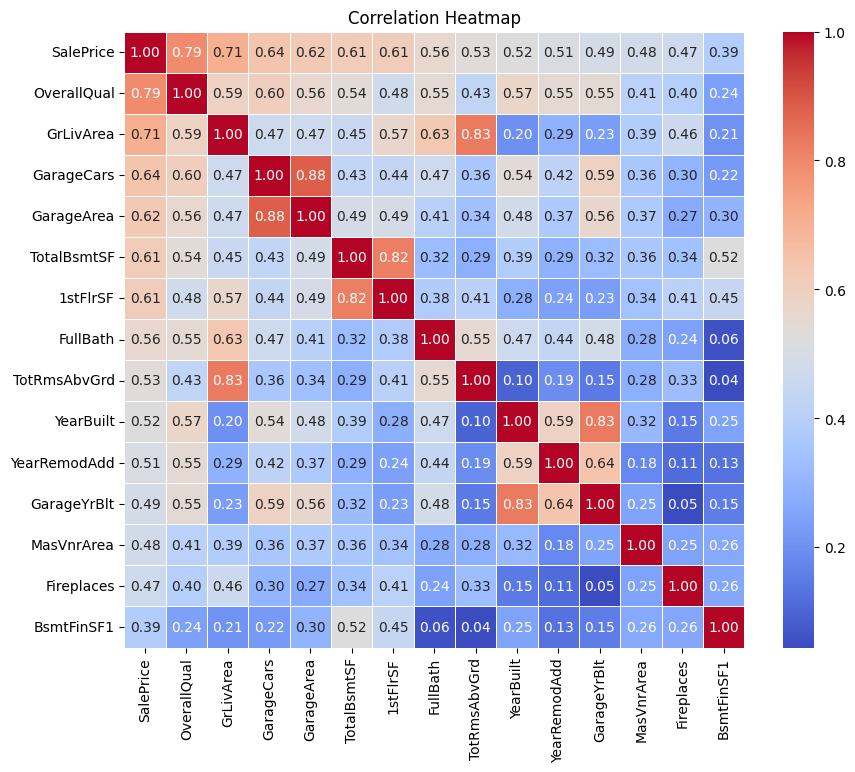

In [9]:
target = 'SalePrice'

corr_matrix = train_df.corr()

corr_matrix = corr_matrix[target].sort_values(ascending=False)
features = corr_matrix.index[1:15]

corr_df = train_df[[target] + list(features)]

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Visualizing top correlated variables

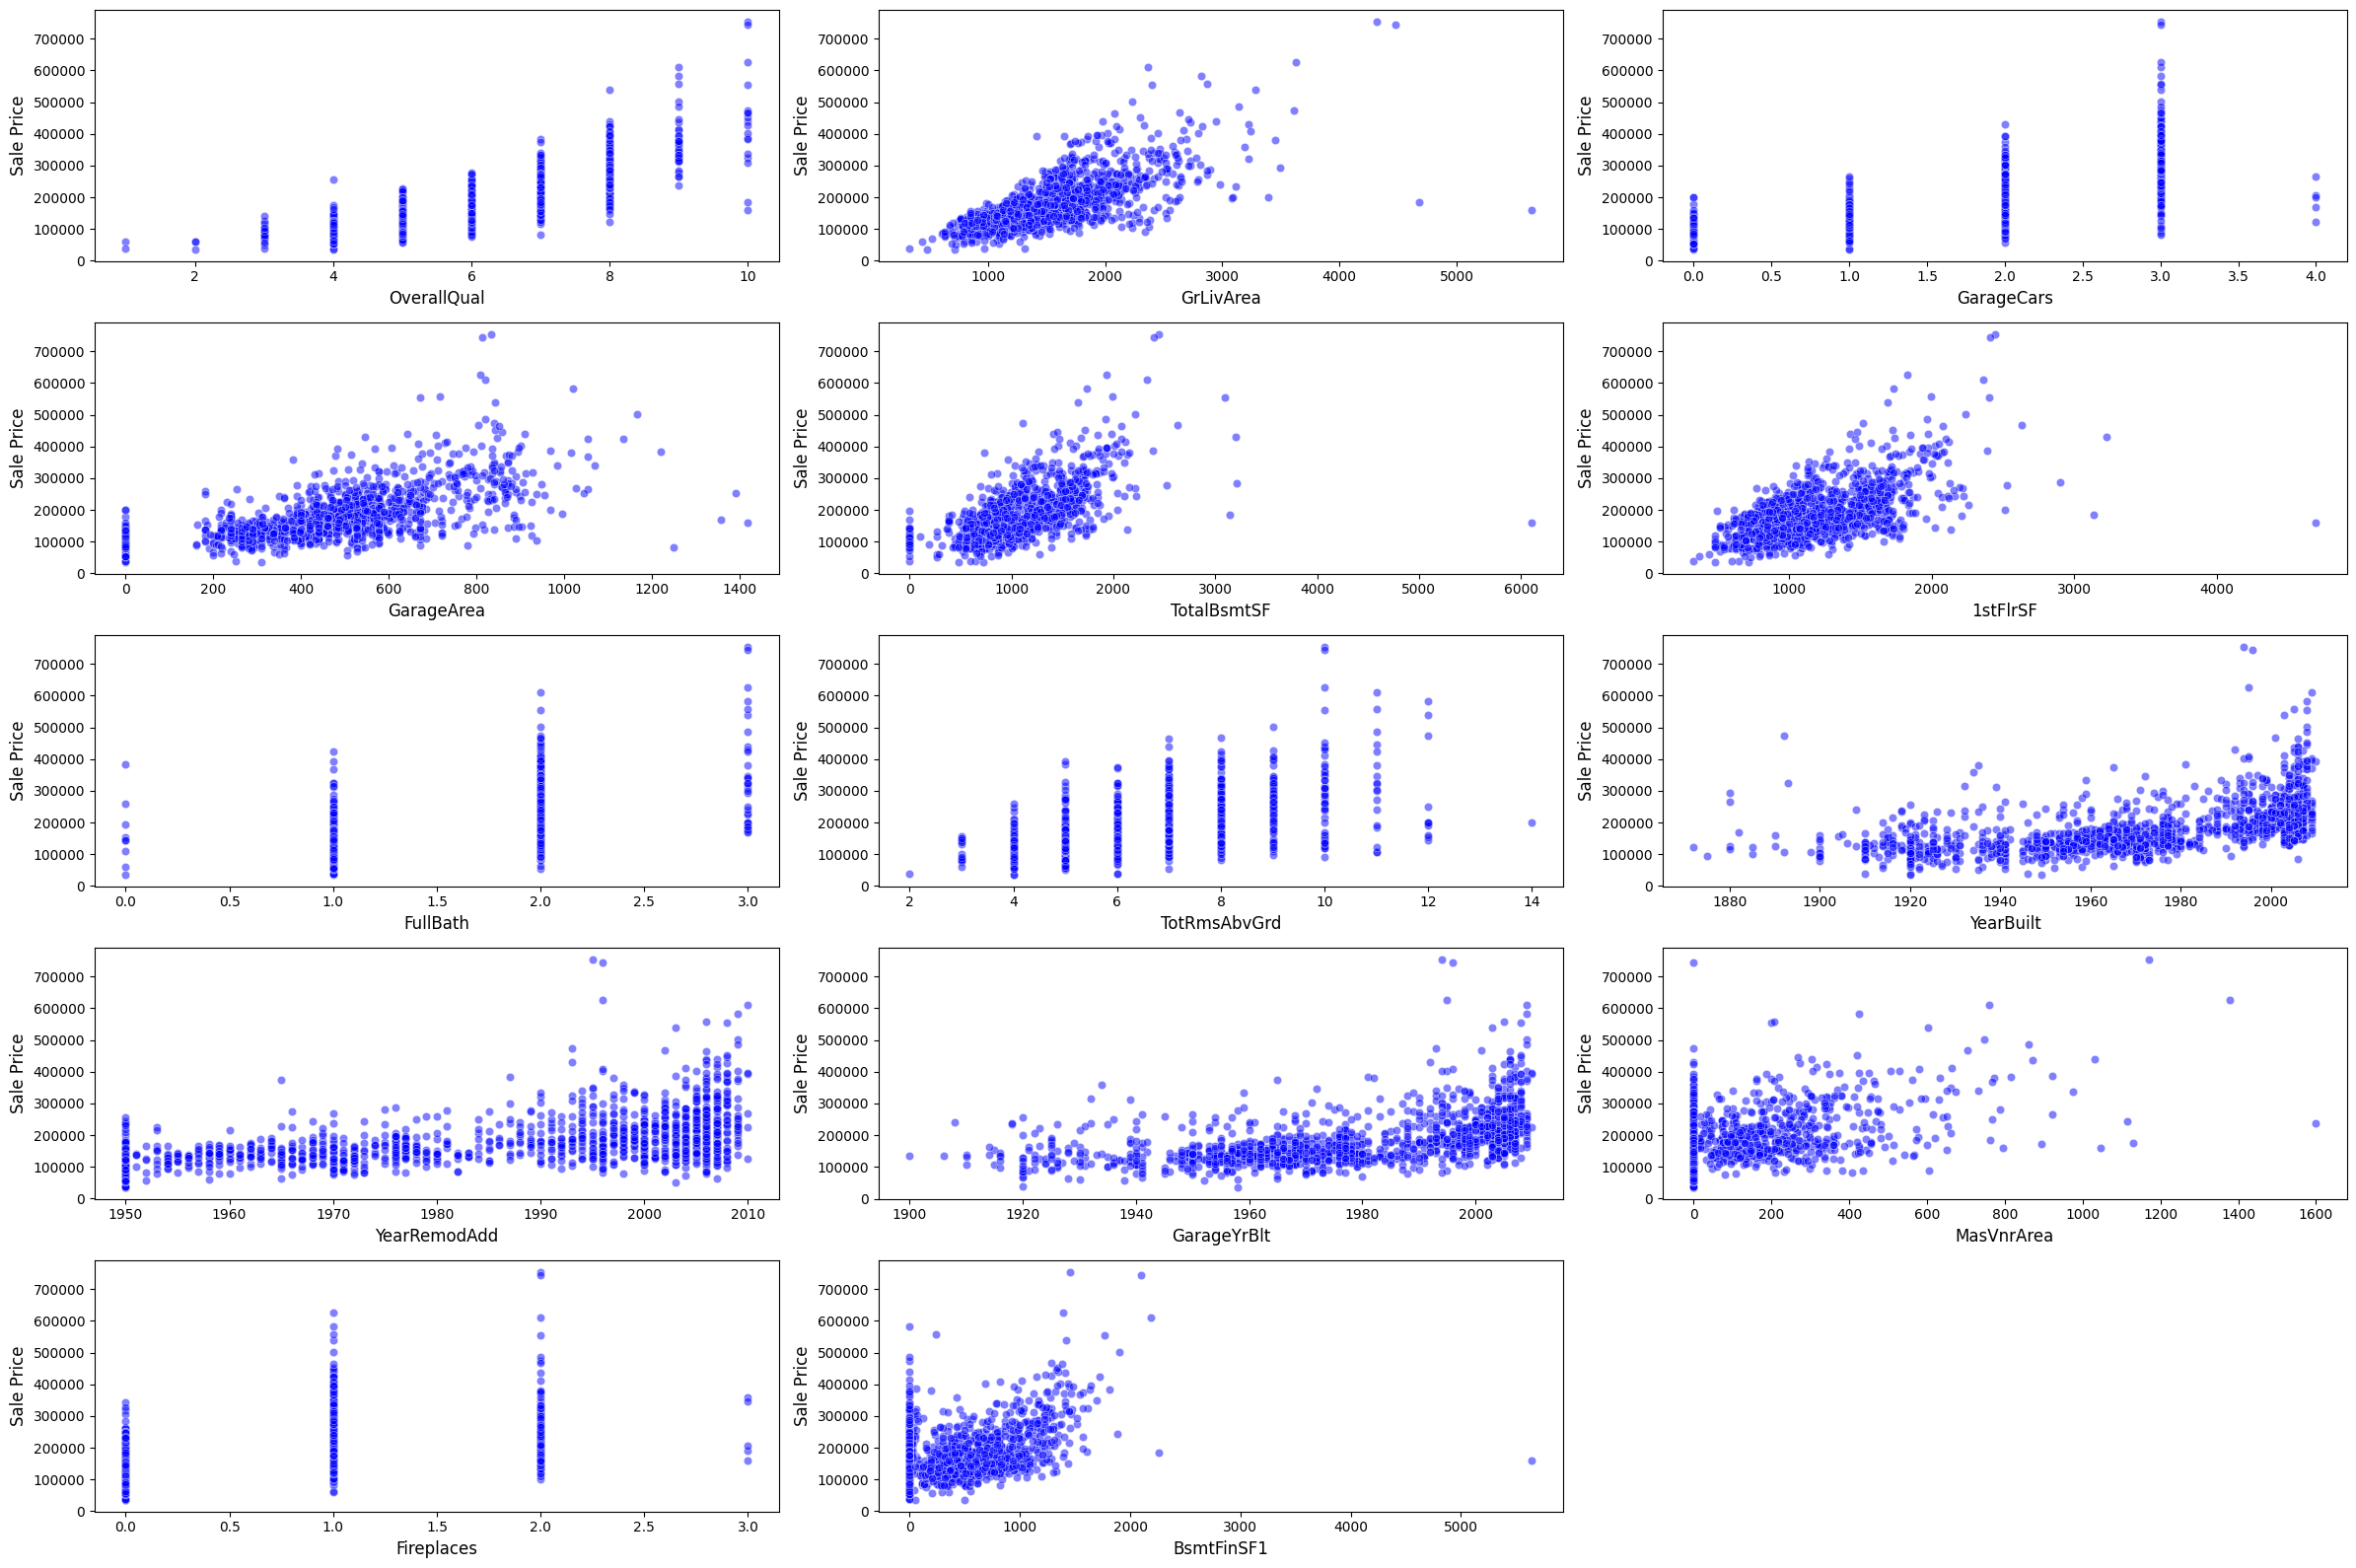

In [10]:
plt.figure(figsize=(24, 16))

for i, feature in enumerate(features, 1):
  plt.subplot(5, 3, i)
  sns.scatterplot(x=feature, y=target, data=train_df, color='b', alpha=0.5)
  plt.xlabel(feature, fontsize = 12)
  plt.ylabel('Sale Price', fontsize=12)

plt.tight_layout()
plt.show()

Visualizing distribution of 'SalePrice'

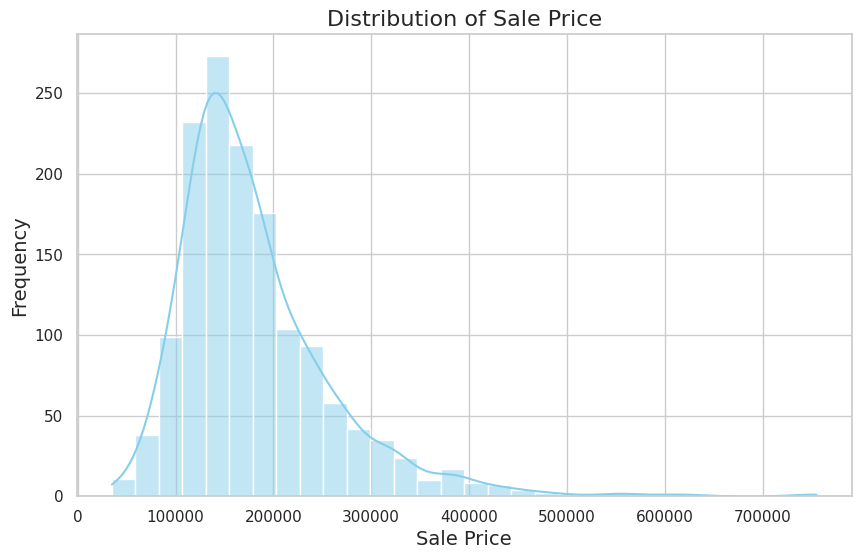

In [11]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(train_df[target], kde=True, color='skyblue', bins=30)

plt.xlabel('Sale Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Sale Price', fontsize=16)

plt.show()

In [12]:
print("Skew: %f" % train_df['SalePrice'].skew())

Skew: 1.882876


## Feature Engineering

Normalizing Distribution with log transformation

In [13]:
train_df[target] = np.log1p(train_df[target])
print("Skew: %f" % train_df['SalePrice'].skew())

Skew: 0.121347


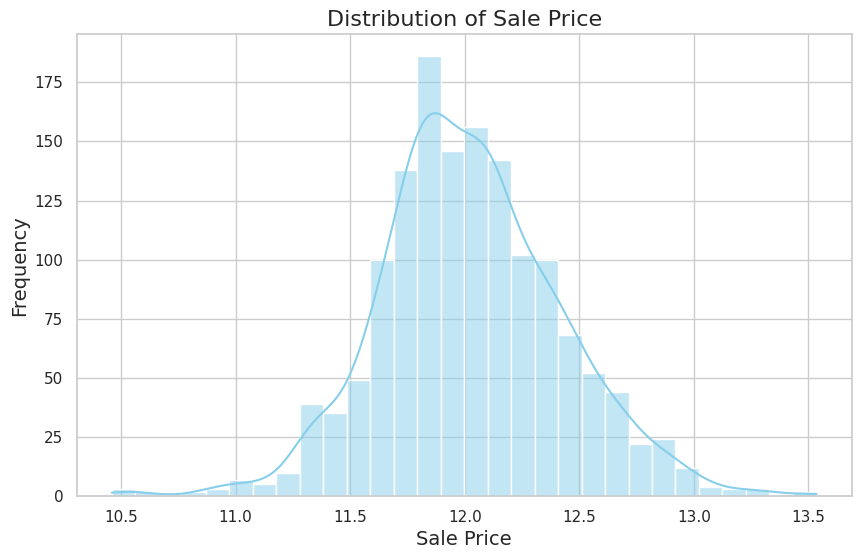

In [14]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(train_df[target], kde=True, color='skyblue', bins=30)

plt.xlabel('Sale Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Sale Price', fontsize=16)

plt.show()

Removing Outliers of top Features

In [15]:
train_df.drop(train_df[(train_df['OverallQual'] < 4) & (train_df['SalePrice'] > 300000)].index, inplace=True)
train_df.drop(train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 300000)].index, inplace=True)
train_df.drop(train_df[(train_df['GarageArea'] > 1200) & (train_df['SalePrice'] < 200000)].index, inplace=True)
train_df.drop(train_df[(train_df['TotalBsmtSF'] > 5000) & (train_df['SalePrice'] < 300000)].index, inplace=True)

train_df.reset_index(drop=True, inplace=True)

Splitting Data

In [16]:
train_target = train_df['SalePrice'].reset_index(drop=True)

train_features = train_df.drop(['SalePrice'], axis=1)

test_features = test_df

combined_features = pd.concat([train_features, test_features]).reset_index(drop=True)

Filling in missing values

In [17]:
def check_missing_values(df):
    missing_values = df.isnull().sum()
    return missing_values

with pd.option_context('display.max_rows', None):
  print(check_missing_values(combined_features))

MSSubClass          0
MSZoning            4
LotFrontage       485
LotArea             0
Street              0
Alley            2713
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
MasVnrArea         23
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinSF1          1
BsmtFinType2       80
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea 

Getting most common values

In [18]:
print(f"MSZoning mode: {combined_features['MSZoning'].mode()[0]}")
print(f"Exterior1st mode: {combined_features['Exterior1st'].mode()[0]}")
print(f"Exterior2nd mode: {combined_features['Exterior2nd'].mode()[0]}")
print(f"Electrical mode: {combined_features['Electrical'].mode()[0]}")
print(f"KitchenQual mode: {combined_features['KitchenQual'].mode()[0]}")
print(f"SaleType mode: {combined_features['SaleType'].mode()[0]}")
print(f"Functional mode: {combined_features['Functional'].mode()[0]}")
print(f"MasVnrType mode: {combined_features['MasVnrType'].mode()[0]}")
print(f"Alley mode: {combined_features['Alley'].mode()[0]}")

MSZoning mode: RL
Exterior1st mode: VinylSd
Exterior2nd mode: VinylSd
Electrical mode: SBrkr
KitchenQual mode: TA
SaleType mode: WD
Functional mode: Typ
MasVnrType mode: None
Alley mode: Grvl


In [19]:
print(f"LotFrontage median: {combined_features['LotFrontage'].median()}")

LotFrontage median: 68.0


In [20]:
combined_features['Alley'].fillna('Grvl', inplace=True)

combined_features['FireplaceQu'].fillna('None', inplace=True)

combined_features['PoolQC'].fillna('None', inplace=True)

combined_features['Fence'].fillna('None', inplace=True)

combined_features['MiscFeature'].fillna('None', inplace=True)

combined_features['LotFrontage'] = combined_features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

combined_features["MasVnrArea"]  = combined_features.groupby("MasVnrType")["MasVnrArea"].transform(lambda x: x.fillna(x.median()))

combined_features['Functional'].fillna('Typ', inplace=True)

combined_features['Electrical'].fillna('SBrkr', inplace=True)

combined_features['KitchenQual'].fillna('TA', inplace=True)

combined_features['MasVnrType'].fillna('None', inplace=True)

combined_features['Exterior1st'].fillna('VinylSd', inplace=True)
combined_features['Exterior2nd'].fillna('VinylSd', inplace=True)

combined_features['SaleType'].fillna('WD', inplace=True)

combined_features['MSZoning'] = combined_features.groupby('Neighborhood')['MSZoning'].transform(lambda x: x.fillna(x.mode().iloc[0]))

garage_columns = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
for i in garage_columns:
  combined_features[i].fillna('No_Garage', inplace=True)

combined_features['LotFrontage'].fillna(63.0, inplace=True)

Filling in rest with Nones or 0s

In [21]:
categorical = []
for i in combined_features.columns:
      if combined_features[i].dtype == object:
          categorical.append(i)
      combined_features.update(combined_features[categorical].fillna('None'))

numeric_types = ['float64','int64']
numeric = []
for i in combined_features.columns:
      if combined_features[i].dtype in numeric_types:
            numeric.append(i)
      combined_features.update(combined_features[numeric].fillna(0.0))

In [22]:
with pd.option_context('display.max_rows', None):
  print(check_missing_values(combined_features))

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual 

Splitting Column Types

In [23]:
numerical_columns = combined_features.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = combined_features.select_dtypes(include=['object', 'category']).columns.tolist()

print(f'Length of numerical: {len(numerical_columns)}')
print(f'Length of categorical: {len(categorical_columns)}')

Length of numerical: 35
Length of categorical: 44


Correct Skewed Features

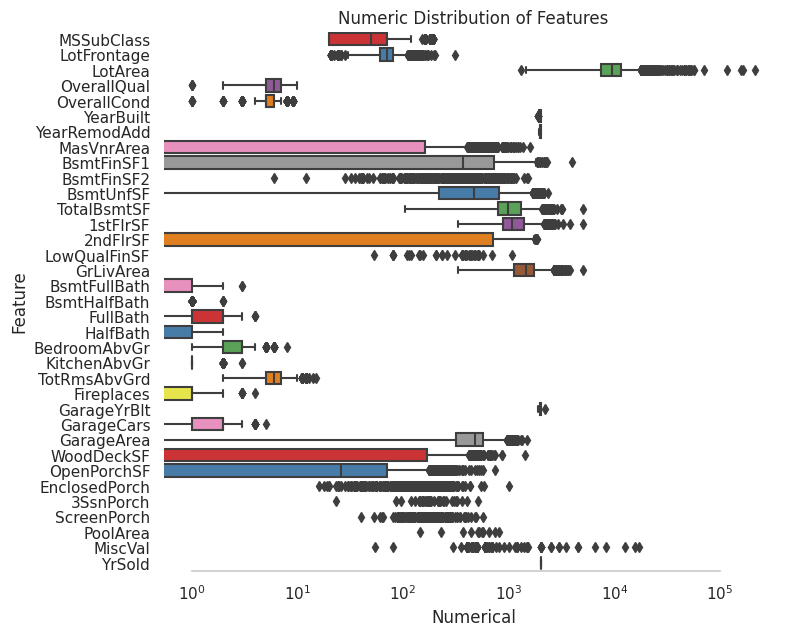

In [24]:
numerical_columns_without_saleprice = [col for col in numerical_columns if col != 'SalePrice']

f, ax = plt.subplots(figsize=(8,7))
ax.set_xscale('log')
ax = sns.boxplot(data=combined_features[numerical_columns_without_saleprice], orient='h', palette = 'Set1')
ax.xaxis.grid(False)
ax.set(ylabel = 'Feature')
ax.set(xlabel = 'Numerical')
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [25]:
skewed = combined_features[numerical_columns_without_saleprice].apply(lambda x: skew(x)).sort_values(ascending=False)

skew_vals = skewed[skewed > .65]
skew_index = skew_vals.index
skewness = pd.DataFrame({'Skew' :skew_vals})

print(skew_vals)

MiscVal          21.926841
PoolArea         18.688884
LotArea          13.176757
LowQualFinSF     12.071863
3SsnPorch        11.360117
KitchenAbvGr      4.295433
BsmtFinSF2        4.139580
EnclosedPorch     3.997699
ScreenPorch       3.940320
BsmtHalfBath      3.939684
MasVnrArea        2.606038
OpenPorchSF       2.528430
WoodDeckSF        1.850890
MSSubClass        1.372967
1stFlrSF          1.256458
LotFrontage       1.096368
GrLivArea         0.980269
BsmtFinSF1        0.974254
BsmtUnfSF         0.915713
2ndFlrSF          0.841159
TotRmsAbvGrd      0.750677
Fireplaces        0.727228
HalfBath          0.698190
TotalBsmtSF       0.662004
dtype: float64


In [26]:
for i in skew_index:
  combined_features[i] = boxcox1p(combined_features[i], boxcox_normmax(combined_features[i] + 1))

skewed = combined_features[numerical_columns_without_saleprice].apply(lambda x: skew(x)).sort_values(ascending=False)

skew_vals = skewed[skewed > .65]
skew_index = skew_vals.index
skewness = pd.DataFrame({'Skew' :skew_vals})

print(skew_vals)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


PoolArea         16.278787
3SsnPorch         8.852740
LowQualFinSF      8.483647
MiscVal           5.259475
BsmtHalfBath      3.787816
KitchenAbvGr      3.773653
ScreenPorch       3.148790
BsmtFinSF2        2.574910
EnclosedPorch     2.146056
MasVnrArea        0.979668
2ndFlrSF          0.891221
WoodDeckSF        0.786498
HalfBath          0.733931
dtype: float64


Dropping features that still have high skew

In [27]:
drop_cols = ['MiscVal']
combined_features.drop(drop_cols, axis=1, inplace=True)

Creating New Features

In [28]:
combined_features['Has_Pool'] = (combined_features['PoolArea']== 0) * 1

combined_features['Has_Fireplace'] = (combined_features['Fireplaces']== 0) * 1

combined_features['AgeAtSale'] = combined_features['YrSold'] - combined_features['YearBuilt']

combined_features['Abnormal_Condition'] = (combined_features['SaleCondition']== 'Abnorml') * 1

old_years = list(range(1800, 1930))
combined_features['Old_House'] = (combined_features['YearBuilt'].apply(lambda year: 1 if year in old_years else 0))

railroad = ['RRAe', 'RRAn', 'RRNe', 'RRNn']
combined_features['Railroad_House'] = (combined_features['Condition1'].apply(lambda rail: 1 if rail in railroad else 0))

combined_features['Non_AirConditioning'] = (combined_features['CentralAir']== 'N') * 1

combined_features['Total_Bathrooms'] = (combined_features["FullBath"] + (0.5 * combined_features["HalfBath"]) + combined_features["BsmtFullBath"] + (0.5 * combined_features["BsmtHalfBath"]))

combined_features['Total_Porch_SF'] = (combined_features['OpenPorchSF'] + combined_features['3SsnPorch'] + combined_features['EnclosedPorch'] + combined_features['ScreenPorch'] + combined_features['WoodDeckSF'])

combined_features['Total_square_footage'] = (combined_features['BsmtFinSF1'] + combined_features['BsmtFinSF2'] + combined_features['1stFlrSF'] + combined_features['2ndFlrSF'])

Dropping Unecessary Features

In [29]:
correlation_matrix = train_df.corr()

correlation_with_target = correlation_matrix['SalePrice'].abs()

correlation_threshold = 0.25

selected_features = correlation_with_target[correlation_with_target <= correlation_threshold].index.tolist()

print(correlation_with_target[correlation_with_target <= correlation_threshold])

MSSubClass       0.074557
OverallCond      0.037628
BsmtFinSF2       0.006717
BsmtUnfSF        0.223847
LowQualFinSF     0.037700
BsmtFullBath     0.237826
BsmtHalfBath     0.014791
BedroomAbvGr     0.205005
KitchenAbvGr     0.148152
EnclosedPorch    0.148776
3SsnPorch        0.056350
ScreenPorch      0.124514
PoolArea         0.040860
MiscVal          0.018324
YrSold           0.035108
Name: SalePrice, dtype: float64


<ipython-input-29-1c07ef08e6db>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_df.corr()


In [30]:
drop_cols = ['LowQualFinSF', 'LowQualFinSF', 'PoolArea', 'BsmtFinSF2', 'BsmtFinSF2', 'YearBuilt','YrSold', 'ScreenPorch', '3SsnPorch', 'BsmtUnfSF']
combined_features.drop(drop_cols, axis=1, inplace=True)

Encode Categorical Variables

In [31]:
cols = ["HouseStyle","ExterQual","ExterCond","BsmtQual","BsmtCond","BsmtExposure","Electrical","KitchenQual",
        "GarageQual","GarageCond"]

encoder = LabelEncoder()

combined_features[cols] = combined_features[cols].apply(encoder.fit_transform)

In [32]:
cols = combined_features.select_dtypes(include="object").columns
combined_features = pd.get_dummies(combined_features, columns=cols)

Recreate data splits

In [33]:
X = combined_features.iloc[:len(train_target), :]
X_test = combined_features.iloc[len(train_target):, :]

Feature Scaling

In [34]:
numerical_columns = combined_features.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = combined_features.select_dtypes(include=['object', 'category']).columns.tolist()

In [35]:
scaler = RobustScaler()
X = scaler.fit_transform(X[numerical_columns])
X_test = scaler.fit_transform(X_test[numerical_columns])

In [36]:
x_train, x_test, y_train, y_test = train_test_split(X, train_df['SalePrice'], test_size=0.2, random_state=0)

## Building Model

In [37]:
error_dict = {}

def error_metrics(model, verbose=False):
  model.fit(x_train, y_train)
  y_train_pred= model.predict(x_train)
  y_test_pred = model.predict(x_test)

  mse = mean_squared_error(y_test,y_test_pred)
  mae = mean_absolute_error(y_test,y_test_pred)

  error_dict[model] = f'Error is {mse}'

  print(f"MSE of {model} model: ", mse)
  print(f"MAE of {model} model: ", mae)

Defining Models

In [38]:
linRegressor = LinearRegression()

In [39]:
xgboost = XGBRegressor(verbosity=0)

In [40]:
lgbm = LGBMRegressor()

In [41]:
gradientBoost = GradientBoostingRegressor()

In [42]:
adaBoost = AdaBoostRegressor()

In [43]:
svr = SVR()

In [44]:
randomForest = RandomForestRegressor()

Fitting Models

In [45]:
fitted_xgb = xgboost.fit(X, train_target, verbose=False)

error_metrics(fitted_xgb)

MSE of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) model:  0.0189306674246641
MAE of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=Fa

In [46]:
fitted_lgbm = lgbm.fit(x_train, y_train)

error_metrics(fitted_lgbm)

MSE of LGBMRegressor() model:  0.015363345743960989
MAE of LGBMRegressor() model:  0.09437073082078612


In [47]:
fitted_gradientBoost = gradientBoost.fit(x_train, y_train)

error_metrics(gradientBoost)

MSE of GradientBoostingRegressor() model:  0.014667786585370093
MAE of GradientBoostingRegressor() model:  0.09055560081368744


In [48]:
fitted_adaBoost = adaBoost.fit(x_train, y_train)

error_metrics(adaBoost)

MSE of AdaBoostRegressor() model:  0.029870679808926662
MAE of AdaBoostRegressor() model:  0.14018249994050494


In [49]:
fitted_svm = svr.fit(x_train, y_train)

error_metrics(fitted_svm)

MSE of SVR() model:  0.014725742014198814
MAE of SVR() model:  0.09013337362354232


In [50]:
fitted_randomForest = randomForest.fit(x_train, y_train)

error_metrics(randomForest)

MSE of RandomForestRegressor() model:  0.016219986051150555
MAE of RandomForestRegressor() model:  0.09449804222568896


Viewing all model's metrics

In [51]:
model_names = ["fitted_xgb", "fitted_lgbm", "fitted_gradientBoost", "fitted_adaBoost", "fitted_svm", "fitted_randomForest"]

values = []
for val in error_dict:
  values.append(error_dict[val])

error_df = pd.DataFrame({"Model": model_names, "Error": values})

error_df.head(10)

,Model,Error
0,fitted_xgb,Error is 0.0189306674246641
1,fitted_lgbm,Error is 0.015363345743960989
2,fitted_gradientBoost,Error is 0.014667786585370093
3,fitted_adaBoost,Error is 0.029870679808926662
4,fitted_svm,Error is 0.014725742014198814
5,fitted_randomForest,Error is 0.016219986051150555


Hyperparameter Tuning

In [52]:
svm_parameters = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.01]
}

In [53]:
grid_search = GridSearchCV(svr, svm_parameters, cv=5)
grid_search.fit(x_train, y_train)

# Get the best hyperparameters and best model
best_params = grid_search.best_params_

In [54]:
print(best_params)

{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


Fitting new SVM with tuned parameters

In [55]:
svr = SVR(C=0.1, gamma='scale', kernel='linear')

In [56]:
fitted_svm = svr.fit(x_train, y_train)

error_metrics(fitted_svm)

MSE of SVR(C=0.1, kernel='linear') model:  0.011884113593640215
MAE of SVR(C=0.1, kernel='linear') model:  0.08457665276703633


Making Predictions with SVM Model

In [57]:
sub = pd.read_csv('sample_submission.csv')

final_predictions = np.expm1(fitted_svm.predict(X_test))

sub.iloc[:, 1] = np.floor(final_predictions)

<ipython-input-57-f45867bfbe68>:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  sub.iloc[:, 1] = np.floor(final_predictions)


In [58]:
sub.to_csv("final_submission", index=False)